In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_dir = "/mnt/home/dheurtel/ceph/04_inference/sbc/"

In [3]:
sbc_files = [f for f in os.listdir(input_dir)]
sbc_files.sort()
print(sbc_files)

['ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_0.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_1.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_2.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_3.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_4.pt']


In [11]:
# Load files
phi_truth_all = None
phi_samples_all = None
for sbc_file in sbc_files:
    sbc_file = os.path.join(input_dir, sbc_file)
    sbc_data = torch.load(sbc_file)
    phi_truth = sbc_data["rphi_true"].detach().cpu()
    phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
    if phi_truth_all is None:
        phi_truth_all = phi_truth
        phi_samples_all = phi_samples
    else:
        phi_truth_all = torch.cat((phi_truth_all, phi_truth), dim=0)
        phi_samples_all = torch.cat((phi_samples_all, phi_samples), dim=1)
print(phi_truth_all.shape, phi_samples_all.shape)

torch.Size([1280, 2]) torch.Size([1040, 1280, 2])


In [19]:
nb_burning_samples = 100

# Get rid of the burnin samples
phi_samples_all = phi_samples_all[nb_burning_samples:, :, :]

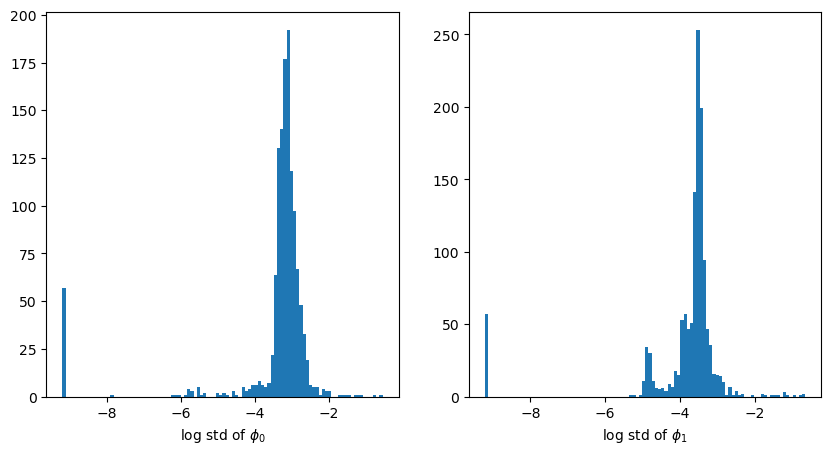

In [20]:
# Show histogram of stds
eps = 1e-4
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(torch.log(phi_samples_all[..., 0].std(dim=0) + eps), bins=100)
axs[0].set_xlabel("log std of $\phi_0$")
axs[1].hist(torch.log(phi_samples_all[..., 1].std(dim=0) + eps), bins=100)
axs[1].set_xlabel("log std of $\phi_1$")
plt.show()

In [21]:
# Remove chains that have not converged

threshold = -7
converged_indices = torch.where(torch.logical_or(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) >= threshold,
                                                 torch.log(phi_samples_all[..., 1].std(dim=0) + eps) >= threshold))[0]
not_converged_indices = torch.where(torch.logical_and(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) < threshold,
                                                      torch.log(phi_samples_all[..., 1].std(dim=0) + eps) < threshold))[0]
print("Number of chains that have not converged:", not_converged_indices.shape[0])

Number of chains that have not converged: 57


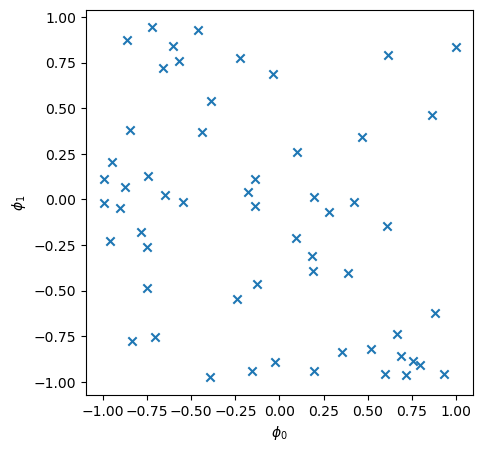

In [24]:
# Plot parameters for the chains that have not converged

plt.figure(figsize=(5, 5))
plt.scatter(phi_truth_all[not_converged_indices, 0], phi_truth_all[not_converged_indices, 1], marker='x')
plt.xlabel("$\phi_0$")
plt.ylabel("$\phi_1$")
plt.show()

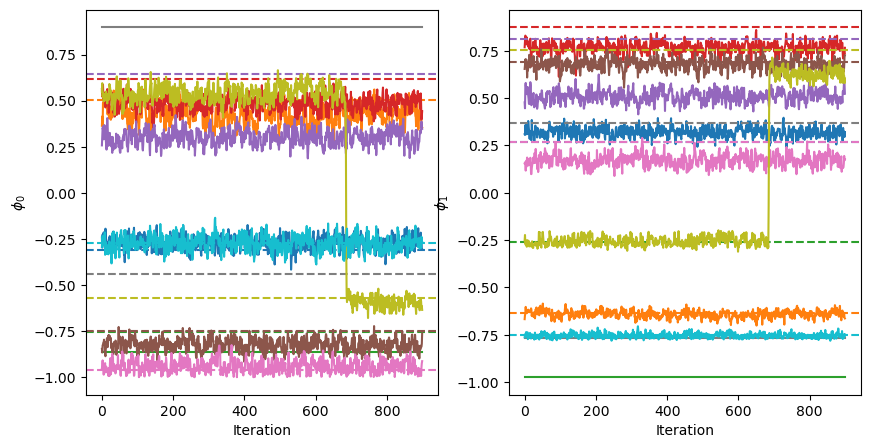

In [33]:
# Plot randomly selected chains
nb_plot_chains = 10
plot_indices = torch.randperm(phi_samples_all.shape[1])[:nb_plot_chains]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(nb_plot_chains):
    axs[0].plot(phi_samples_all[:, plot_indices[i], 0], color=f'C{i}')
    axs[0].axhline(phi_truth_all[plot_indices[i], 0], color=f'C{i}', linestyle='--')
    axs[1].plot(phi_samples_all[:, plot_indices[i], 1], color=f'C{i}')
    axs[1].axhline(phi_truth_all[plot_indices[i], 1], color=f'C{i}', linestyle='--')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("$\phi_0$")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("$\phi_1$")
plt.show()

In [35]:
# Compute rank statistics
phi_truth_all_converged = phi_truth_all[converged_indices, :]
phi_samples_all_converged = phi_samples_all[:, converged_indices, :]
ranks = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
for i in range(phi_truth_all_converged.shape[0]):
    for j in range(phi_truth_all_converged.shape[1]):
        ranks[i, j] = torch.mean((phi_samples_all_converged[:, i, j] < phi_truth_all_converged[i, j]).float())

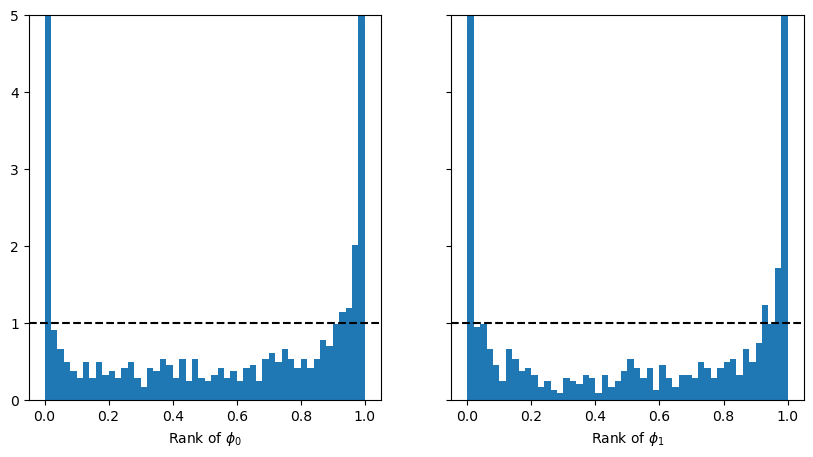

In [40]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axs[0].hist(ranks[:, 0], bins=50, density=True)
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank of $\phi_0$")
axs[1].hist(ranks[:, 1], bins=50, density=True)
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank of $\phi_1$")
axs[0].set_ylim([0, 5])
plt.show()